# **Implementation of ML on Solar Energy**

## Input Section

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import datetime
import numpy as np
url = "https://github.com/ksuryachandra/Wind-Power-Forecast/blob/main/SolarDataProcessed.xlsx?raw=true"

data = pd.read_excel(url)
nums = [int(str(s)[:2]) for s in data.Time.dt.time]
data.insert(7,"Hour", nums)
months = [int(str(s)[5:7]) for s in data.Time.dt.date]
days = [int(str(s)[8:10]) for s in data.Time.dt.date]
originalyear = [int(str(st)[:4]) for st in data.Time.dt.date]
data.insert(8,"Day", days)
data.insert(9,"Month", months)
data

,Time,Virtual MFM AC Power (kW),Irradiance ( W/m²),GHI (W/m²),POA 1 (W/m²),Mod Temp 1 (°C),Amb Temp (°C),Hour,Day,Month
0,2022-01-01 00:00:00,0.0,0.64,0.32,0.64,17.7,17.8,0,1,1
1,2022-01-01 01:00:00,0.0,0.64,0.32,0.64,17.4,17.6,1,1,1
2,2022-01-01 02:00:00,0.0,0.64,0.32,0.64,17.1,17.5,2,1,1
3,2022-01-01 03:00:00,0.0,0.64,0.32,0.64,16.7,16.5,3,1,1
4,2022-01-01 04:00:00,0.0,0.64,0.32,0.64,16.4,16.3,4,1,1
...,...,...,...,...,...,...,...,...,...,...
9057,2023-01-31 19:00:00,0.0,0.48,0.32,0.48,22.8,23.8,19,31,1
9058,2023-01-31 20:00:00,0.0,0.48,0.32,0.48,20.1,21.5,20,31,1
9059,2023-01-31 21:00:00,0.0,0.48,0.32,0.48,19.3,20.5,21,31,1
9060,2023-01-31 22:00:00,0.0,0.48,0.32,0.48,19.0,19.7,22,31,1


## Temperature Prediction

### Random Forest Regressor

In [ ]:
# Train the model with historical temperature

df = data.copy(deep=True)
df = df.fillna(method='ffill')
X = df.iloc[:,[-1,-2,-3]].to_numpy()
#X = X.reshape(-1,1)
y = df.iloc[:,-4].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=100)

from sklearn.ensemble import RandomForestRegressor

rf0 = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf0.fit(X_train, y_train);

predictions = rf0.predict(X_test)
errors = abs(predictions - y_test)
mape = 100 * (errors / y_test)
accuracyRandForest = 100 - np.mean(mape)
print('Accuracy:', round(accuracyRandForest, 2), '%.')

Accuracy: 95.02 %.


Overall Accuracy: 94.25 %


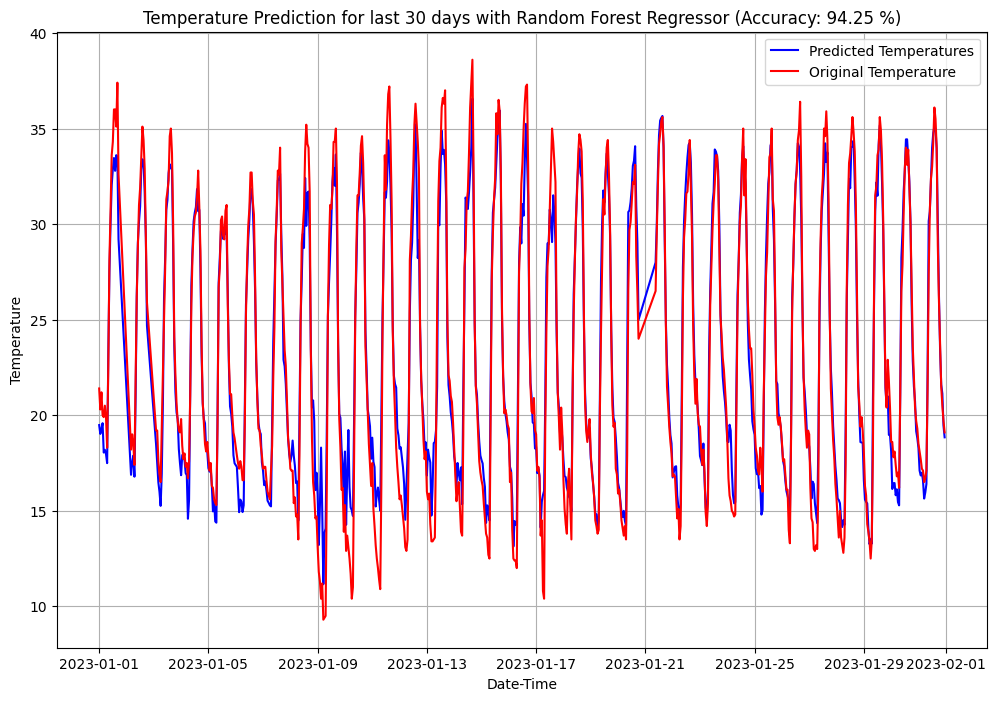

In [ ]:
#Future prediction

start_date = datetime.datetime(2023, 1, 1, 0)  # start date and time
end_date = datetime.datetime(2023, 1, 31, 23)  # end date and time
delta = datetime.timedelta(hours=1)  # hourly interval
difference = end_date - start_date
difference = int(str(difference)[:2])
dates = []
while start_date <= end_date:
    dates.append(start_date)
    start_date += delta
future = []
future1 = []
for date in dates:
    future.append(str(date))
    future1.append(date)

year = [int(s[:4]) for s in future]
mnth = [int(s[5:7]) for s in future]
days = [int(s[8:10]) for s in future]
hour = [int(s[11:13]) for s in future]

future_df = pd.DataFrame({"Month":mnth, "Day" :days, "hour": hour})

newout = rf0.predict(future_df.values)

pred_temp = future_df.iloc[:,:].copy(deep=True)

pred_temp.insert(0,"Date Time", future1)
pred_temp.insert(1,"Predicted Temp", newout)

temp_output1 = pd.DataFrame({"DataTime": pred_temp.iloc[:,0], "Predicted Temperature": pred_temp.iloc[:,1]})

comp_df1 = data.iloc[:,[0,-4]]
merge_df1 = pd.merge(temp_output1, comp_df1, how = "inner", left_on = "DataTime", right_on = "Time")
print("Overall Accuracy: "+str(100 - round((abs(merge_df1.iloc[:,3] - merge_df1.iloc[:,1])/merge_df1.iloc[:,1] * 100 ).mean(),2))+" %")
accur = "Accuracy: "+str(100 - round((abs(merge_df1.iloc[:,3] - merge_df1.iloc[:,1])/merge_df1.iloc[:,1] * 100 ).mean(),2))+" %"
figu = plt.figure(figsize=(12,8))
plt.plot(merge_df1.iloc[:,0], merge_df1.iloc[:,1], color = "blue", label = "Predicted Temperatures")
plt.plot(merge_df1.iloc[:,0], merge_df1.iloc[:,3], color = "red", label = "Original Temperature")
plt.xlabel("Date-Time")
plt.ylabel("Temperature")
plt.title(f"Temperature Prediction for last {difference} days with Random Forest Regressor ({accur})")
plt.legend()
plt.grid()
plt.show()

In [ ]:
merge_df1.iloc[:,[0,1,3]]

,DataTime,Predicted Temperature,Amb Temp (°C)
0,2023-01-01 00:00:00,19.483152,21.4
1,2023-01-01 01:00:00,19.021250,20.3
2,2023-01-01 02:00:00,19.283461,21.2
3,2023-01-01 03:00:00,19.583064,20.0
4,2023-01-01 04:00:00,18.045370,19.9
...,...,...,...
707,2023-01-31 19:00:00,23.440361,23.8
708,2023-01-31 20:00:00,21.600739,21.5
709,2023-01-31 21:00:00,21.129167,20.5
710,2023-01-31 22:00:00,19.457541,19.7


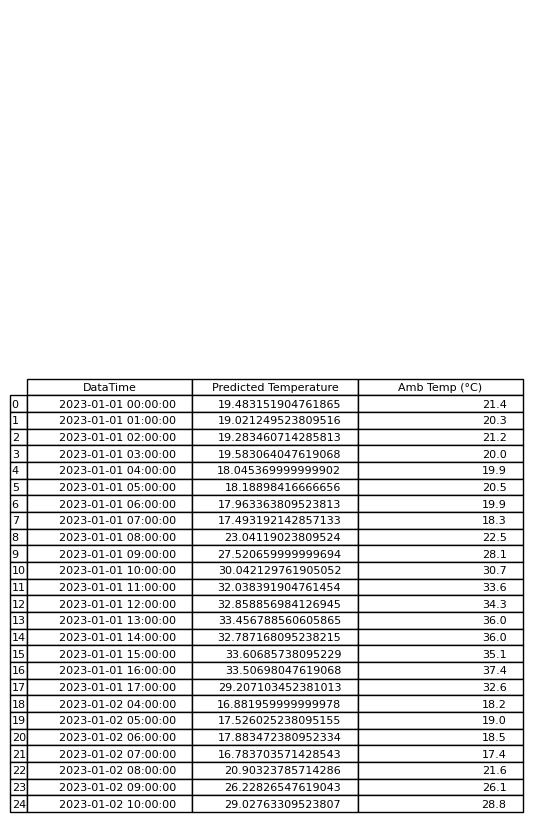

In [ ]:
from pandas.plotting import table # EDIT: see deprecation warnings below

ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, merge_df1.iloc[:25,[0,1,3]])  # where df is your data frame

# plt.savefig('mytable.png')

### XGB Regressor

Overall Accuracy: 95.07 %


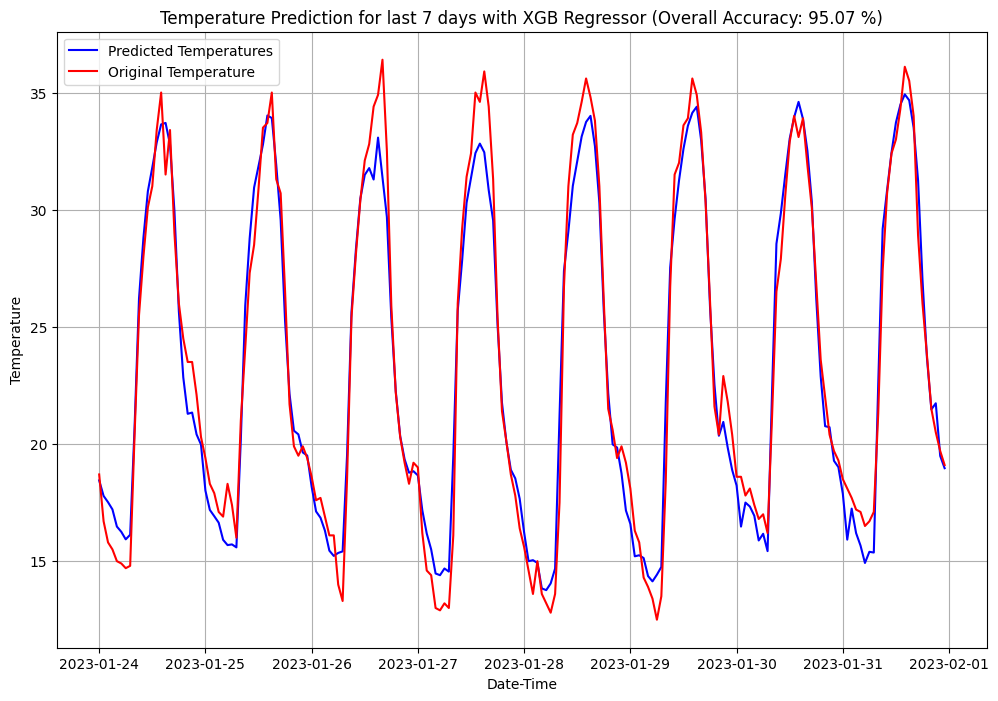

In [ ]:
#Future prediction

start_date = datetime.datetime(2023, 1, 24, 0)  # start date and time
end_date = datetime.datetime(2023, 1, 31, 23)  # end date and time
delta = datetime.timedelta(hours=1)  # hourly interval
difference = end_date - start_date
difference = int(str(difference)[:2])

dates = []
while start_date <= end_date:
    dates.append(start_date)
    start_date += delta
future = []
future1 = []
for date in dates:
    future.append(str(date))
    future1.append(date)

year = [int(s[:4]) for s in future]
mnth = [int(s[5:7]) for s in future]
days = [int(s[8:10]) for s in future]
hour = [int(s[11:13]) for s in future]

future_df = pd.DataFrame({"Month":mnth, "Day" :days, "Hour": hour})

from xgboost import XGBRegressor
X = data.iloc[:,[-1,-2,-3]].values
Y = data.iloc[:,-4].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.33, random_state = 7)

XGB = XGBRegressor()
XGB.fit(X_train, Y_train)

newout = XGB.predict(future_df.values)

pred_temp = future_df.iloc[:,:].copy(deep=True)

pred_temp.insert(0,"Date Time", future1)
pred_temp.insert(1,"Predicted Temp", newout)

temp_output = pd.DataFrame({"DateTime": pred_temp.iloc[:,0], "Predicted Temperature": pred_temp.iloc[:,1]})

comp_df = data.iloc[:,[0,-4]]
merge_df = pd.merge(temp_output, comp_df, how = "inner", left_on = "DateTime", right_on = "Time")
merge_df
print("Overall Accuracy: "+str(100 - round((abs(merge_df.iloc[:,3] - merge_df.iloc[:,1])/merge_df.iloc[:,1] * 100 ).mean(),2))+" %")
accur = "Overall Accuracy: "+str(100 - round((abs(merge_df.iloc[:,3] - merge_df.iloc[:,1])/merge_df.iloc[:,1] * 100 ).mean(),2))+" %"
figu = plt.figure(figsize=(12,8))
plt.plot(merge_df.iloc[:,0], merge_df.iloc[:,1], color = "blue", label = "Predicted Temperatures")
plt.plot(merge_df.iloc[:,0], merge_df.iloc[:,3], color = "red", label = "Original Temperature")
plt.xlabel("Date-Time")
plt.ylabel("Temperature")
plt.title(f"Temperature Prediction for last {difference} days with XGB Regressor ({accur})")
plt.legend()
plt.grid()
plt.show()

### Support Vector Regression

In [ ]:
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler

# Extract the features and target variable
X = data.iloc[:,[-1,-2,-3]].values
y = data.iloc[:,-4].values

# Initialize and train the SVR model
svr_modelT = SVR(kernel='rbf', C = 10, epsilon = 1.0)
svr_modelT.fit(X, y)


SVR(C=10, epsilon=1.0)

#### Hyper parameter tuning for SVR

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

X = data.iloc[:,[-1,-2,-3,-4,-5,-6,-7,-8]].values
y = data.iloc[:,-9].values

# Assuming you have your dataset with input features (X) and target variable (y)

# Define the parameter grid for C and epsilon
param_grid = {'C': [0.1, 1, 10], 'epsilon': [0.01, 0.1, 1]}

# Create the SVR model
svr = SVR(kernel='rbf')

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=5)
grid_search.fit(X, y)

# Print the best hyperparameters found
print("Best C:", grid_search.best_params_['C'])
print("Best epsilon:", grid_search.best_params_['epsilon'])

# Get the best SVR model
best_svr = grid_search.best_estimator_

# Use the best model for prediction
# prediction = best_svr.predict(future_df.values)
# print("Predicted value:", prediction)

Best C: 10
Best epsilon: 0.01


#### Future Prediction using SVR

Overall Accuracy: 91.8 %


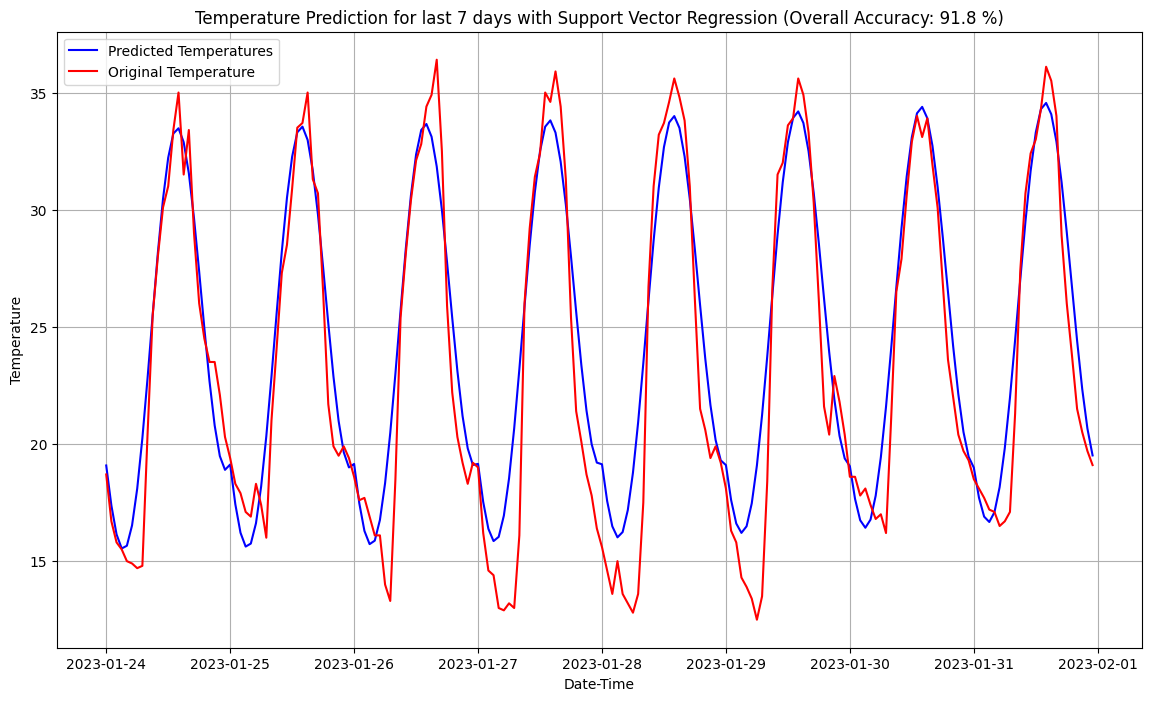

In [ ]:
#Future prediction

start_date = datetime.datetime(2023, 1, 24, 0)  # start date and time
end_date = datetime.datetime(2023, 1, 31, 23)  # end date and time
delta = datetime.timedelta(hours=1)  # hourly interval
difference = end_date - start_date
difference = int(str(difference)[:2])
dates = []
while start_date <= end_date:
    dates.append(start_date)
    start_date += delta
future = []
future1 = []
for date in dates:
    future.append(str(date))
    future1.append(date)

year = [int(s[:4]) for s in future]
mnth = [int(s[5:7]) for s in future]
days = [int(s[8:10]) for s in future]
hour = [int(s[11:13]) for s in future]

future_df = pd.DataFrame({"Month":mnth, "Day" :days, "hour": hour})

newout = svr_modelT.predict(future_df.values)

pred_temp = future_df.iloc[:,:].copy(deep=True)
pred_temp.insert(0,"Date Time", future1)
pred_temp.insert(1,"Predicted Temp", newout)

temp_output1 = pd.DataFrame({"DataTime": pred_temp.iloc[:,0], "Predicted Temperature": pred_temp.iloc[:,1]})

comp_df1 = data.iloc[:,[0,-4]]
merge_df1 = pd.merge(temp_output1, comp_df1, how = "inner", left_on = "DataTime", right_on = "Time")
print("Overall Accuracy: "+str(100 - round((abs(merge_df1.iloc[:,3] - merge_df1.iloc[:,1])/merge_df1.iloc[:,1] * 100 ).mean(),2))+" %")
accur = "Overall Accuracy: "+str(100 - round((abs(merge_df1.iloc[:,3] - merge_df1.iloc[:,1])/merge_df1.iloc[:,1] * 100 ).mean(),2))+" %"

figu = plt.figure(figsize=(14,8))
plt.plot(merge_df1.iloc[:,0], merge_df1.iloc[:,1], color = "blue", label = "Predicted Temperatures")
plt.plot(merge_df1.iloc[:,0], merge_df1.iloc[:,3], color = "red", label = "Original Temperature")
plt.xlabel("Date-Time")
plt.ylabel("Temperature")
plt.title(f"Temperature Prediction for last {difference} days with Support Vector Regression ({accur})")
plt.legend()
plt.grid()
plt.show()

### Long Shot-Term Memory (LSTM)

In [ ]:
!pip install tensorflow

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
# Load the dataset
#data = data.iloc[:,[0,6]]  # Replace 'temperature_data.csv' with your actual dataset file
# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Amb Temp (°C)'].values.reshape(-1, 1))
# Split the data into training and testing sets
train_ratio = 0.8
train_size = int(len(scaled_data) * train_ratio)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]
# Function to create input sequences and corresponding labels
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)
# Set the sequence length
sequence_length = 24  # Adjust the sequence length as per your preference

# Create input sequences and labels for training and testing
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Build the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(sequence_length, 1)))
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)
# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse scale the predictions
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)

# Print some sample predictions
print("Sample predictions:")
for i in range(10):
    print(f"Predicted: {test_predictions[i]}, Actual: {scaler.inverse_transform(y_test[i].reshape(-1, 1))}")

# Evaluate the model
train_rmse = np.sqrt(np.mean((train_predictions - scaler.inverse_transform(y_train.reshape(-1, 1)))**2))
test_rmse = np.sqrt(np.mean((test_predictions - scaler.inverse_transform(y_test.reshape(-1, 1)))**2))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Epoch 1/10
226/226 [==============================] - 14s 31ms/step - loss: 0.0185
Epoch 2/10
226/226 [==============================] - 9s 38ms/step - loss: 0.0045
Epoch 3/10
226/226 [==============================] - 9s 39ms/step - loss: 0.0034
Epoch 4/10
226/226 [==============================] - 7s 29ms/step - loss: 0.0031
Epoch 5/10
226/226 [==============================] - 6s 25ms/step - loss: 0.0029
Epoch 6/10
226/226 [==============================] - 3s 15ms/step - loss: 0.0027
Epoch 7/10
226/226 [==============================] - 3s 15ms/step - loss: 0.0025
Epoch 8/10
226/226 [==============================] - 4s 16ms/step - loss: 0.0024
Epoch 9/10
226/226 [==============================] - 4s 18ms/step - loss: 0.0024
Epoch 10/10
56/56 [==============================] - 0s 6ms/step
Sample predictions:
Predicted: [22.323349], Actual: [[20.7]]
Predicted: [23.63477], Actual: [[24.4]]
Predicted: [26.924326], Actual: [[28.3]]
Predicted: [30.145557], Actual: [[34.]]
Predicted: [34

6/6 [==============================] - 0s 6ms/step
Overall Accuracy: 94.51 %


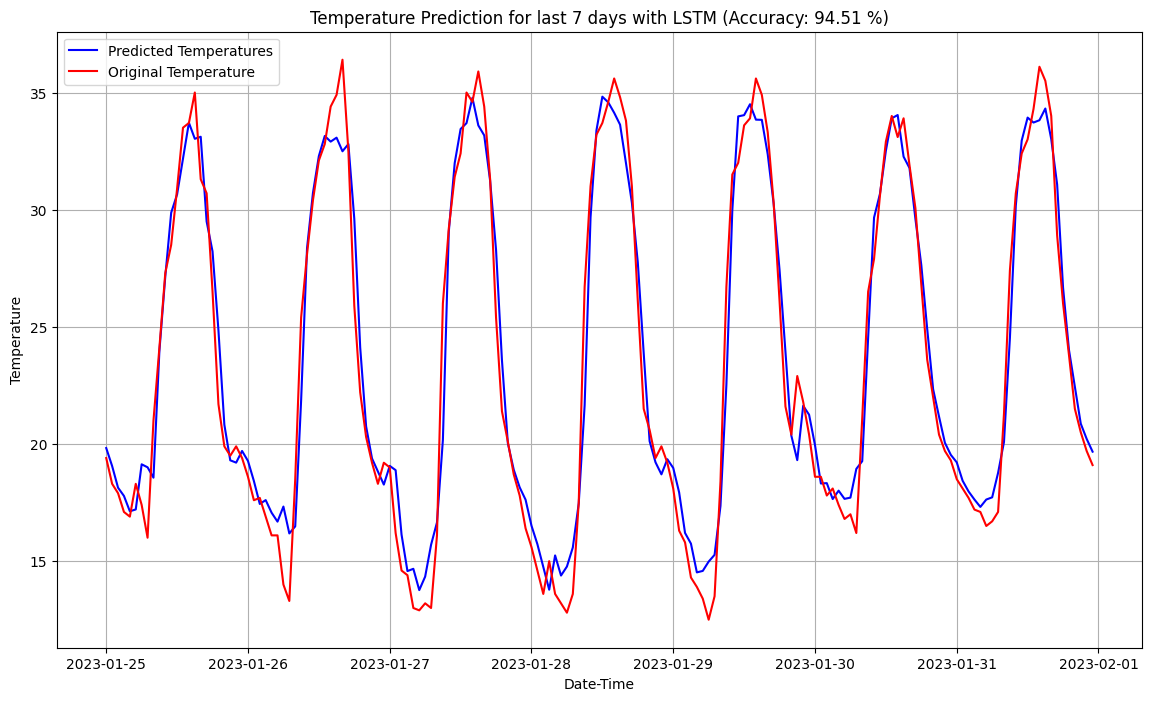

In [ ]:
start_date = datetime.datetime(2023, 1, 24, 0)  # start date and time
end_date = datetime.datetime(2023, 1, 31, 23)  # end date and time
delta = datetime.timedelta(hours=1)  # hourly interval
difference = end_date - start_date
difference = int(str(difference)[:2])

dates = []
while start_date <= end_date:
    dates.append(start_date)
    start_date += delta
future = []
future1 = []
for date in dates:
    future.append(str(date))
    future1.append(date)

year = [int(s[:4]) for s in future]
mnth = [int(s[5:7]) for s in future]
days = [int(s[8:10]) for s in future]
hour = [int(s[11:13]) for s in future]

future_df3 = pd.DataFrame({"Date-Time": future1})
# future_df3.insert(1, "Predictions", future_predictions)
# future_df3.iloc[:,1] = [float(s) for s in future_df3.iloc[:,1]]
cmp_df = pd.merge(future_df3, data, how = "inner", left_on = "Date-Time", right_on = "Time")
test_scaled_data = scaler.fit_transform(cmp_df['Amb Temp (°C)'].values.reshape(-1, 1))
test_scaled_sequence, y = create_sequences(test_scaled_data, sequence_length )
test_scaled_sequence.shape
out = model.predict(test_scaled_sequence)
out = scaler.inverse_transform(out)
cmp_df = cmp_df.iloc[24:,[0,7]]
cmp_df.insert(2, "Predicted_Temperature", out)


merge_df1 = cmp_df.copy(deep=True)
print("Overall Accuracy: "+str(100 - round((abs(cmp_df.iloc[:,1] - cmp_df.iloc[:,2])/cmp_df.iloc[:,1] * 100).mean(),2))+" %")
accur = "Accuracy: "+str(100 - round((abs(cmp_df.iloc[:,1] - cmp_df.iloc[:,2])/cmp_df.iloc[:,1] * 100).mean(),2))+" %"

figu = plt.figure(figsize=(14,8))
plt.plot(merge_df1.iloc[:,0], merge_df1.iloc[:,2], color = "blue", label = "Predicted Temperatures")
plt.plot(merge_df1.iloc[:,0], merge_df1.iloc[:,1], color = "red", label = "Original Temperature")
plt.xlabel("Date-Time")
plt.ylabel("Temperature")
plt.title(f"Temperature Prediction for last {difference} days with LSTM ({accur})")
plt.legend()
plt.grid()
plt.show()

In [ ]:
figu.savefig("LSTM_Temperature_L7D.svg", format = 'svg')

In [ ]:
import pickle
filename = 'LSTM_model_Temperature.sav'
pickle.dump(model, open(filename, 'wb'))
loaded_model1 = pickle.load(open(filename, 'rb'))
result = loaded_model1.predict(test_scaled_sequence)
print(result)

## Solar Power Prediction

### All Parameter Prediction - XGB Regression

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
#%matplotlib inline

# Convert the date and time columns to a pandas datetime object
data = pd.read_excel('https://github.com/ksuryachandra/Wind-Power-Forecast/blob/main/SolarDataProcessed.xlsx?raw=true')
data1 = data
nums = [int(str(s)[:2]) for s in data.Time.dt.time]
data.insert(7,"Hour", nums)
months = [int(str(s)[5:7]) for s in data.Time.dt.date]
days = [int(str(s)[8:10]) for s in data.Time.dt.date]
originalyear = [int(str(st)[:4]) for st in data.Time.dt.date]
data.insert(8,"Day", days)
data.insert(9,"Month", months)
from xgboost import XGBRegressor

X = data.iloc[:,[-1,-2,-3,-4]].values
Y = data.iloc[:,-5].values
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
model0 = XGBRegressor()
model0.fit(X_train, y_train)
y_pred = model0.predict(X)
y_pred

In [ ]:
mod_df = data.iloc[:,[-1,-2,-3,-4]].copy(deep=True)
mod_df.insert(4,"Pred Mod Temp", y_pred)

In [ ]:
X = df.iloc[:,[-1,-2,-3,-4,-5]].to_numpy()
y = df.iloc[:,-6].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=100)

model1 = XGBRegressor()
model1.fit(X_train, y_train)

predictions = model1.predict(X_test)
predictions = model1.predict(mod_df.values)
predictions

In [ ]:
POA_df = data.iloc[:,[-1,-2,-3,-4]].copy(deep=True)
POA_df.insert(4,"Pred Mod Temp", mod_df.iloc[:,-1])
POA_df.insert(5,"Pred POA", predictions)
POA_df

In [ ]:
X = df.iloc[:,[-1,-2,-3,-4,-5,-6]].to_numpy()
y = df.iloc[:,-7].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=100)

model2 = XGBRegressor()
model2.fit(X_train, y_train)

predictions = model2.predict(X)
predictions = model2.predict(POA_df.values)
predictions

In [ ]:
GHI_df = data.iloc[:,[-1,-2,-3,-4]].copy(deep=True)
GHI_df.insert(4,"Pred Mod Temp", mod_df.iloc[:,-1])
GHI_df.insert(5,"Pred POA", POA_df.iloc[:,-1])
GHI_df.insert(6,"Pred GHI", predictions)
GHI_df

In [ ]:
X = df.iloc[:,[-1,-2,-3,-4,-5,-6,-7]].to_numpy()
y = df.iloc[:,-8].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=100)

model3 = XGBRegressor()
model3.fit(X_train, y_train)

predictions = model3.predict(X_test)
predictions = model3.predict(GHI_df.values)
predictions

In [ ]:
Rad_df = GHI_df.copy(deep=True)
Rad_df.insert(7,"Pred Irradiance",predictions)
Rad_df

In [ ]:
X = df.iloc[:,[-1,-2,-3,-4,-5,-6,-7,-8]].to_numpy()
#X = X.reshape(-1,1)
y = df.iloc[:,-9].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=100)


model4 = XGBRegressor()
model4.fit(X_train, y_train)

predictions = model4.predict(Rad_df.values)
accuracyRandForest = 100 - np.mean(mape)

In [ ]:
finale = Rad_df.copy(deep = True)
finale.insert(8,"Pred Power",predictions)
finale

In [ ]:
check_df = data.iloc[:,[-1,-2,-3,-4,-5,-6,-7,-8,-9]].copy(deep=True)
check_df

In [ ]:
# Temperature
X = data.iloc[:,[-1,-2,-3]].values
Y = data.iloc[:,-4].values
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
modelT = XGBRegressor()
modelT.fit(X_train, y_train)
y_pred = modelT.predict(X)
y_pred
test_df = pd.DataFrame({"DateTime":data.iloc[:,0], "Predicted Temperature":y_pred})
test_df.iloc[]

In [ ]:
accur = []
print("Temperature Prediction Accuracy: " + str(round((100 - (abs(check_df.iloc[:,3]-test_df.iloc[:,1])/check_df.iloc[:,3])*100).mean(),2)) + " %\n")
for i in range(4,8):
  accur.append((100 - (abs(check_df.iloc[:,i]-finale.iloc[:,i])/check_df.iloc[:,i])*100).mean())
lst1 = []
for i in range(len(finale)):
  if finale.iloc[i,-1] !=0 and check_df.iloc[i,-1] != 0:
    lst1.append((100 - (abs(check_df.iloc[i,-1]-finale.iloc[i,-1])/check_df.iloc[i,-1])*100).mean())
accur.append(sum(lst1)/len(lst1))
print("Accuracy of ")
for j in range(4,9):
  print(f"{check_df.columns[j]}: " + str(round(accur[j-4],2)) + " %")

print("\n Overall Accuracy: " +str(sum(accur)/len(accur)) + " %")

In [ ]:
accur = []
for i in range(4,8):
  accur.append((100 - (abs(check_df.iloc[:,i]-finale.iloc[:,i])/check_df.iloc[:,i])*100).mean())
lst1 = []
for i in range(len(finale)):
  if finale.iloc[i,-1] !=0 and check_df.iloc[i,-1] != 0:
    lst1.append((100 - (abs(check_df.iloc[i,-1]-finale.iloc[i,-1])/check_df.iloc[i,-1])*100).mean())
accur.append(sum(lst1)/len(lst1))
accur


In [ ]:
import datetime

start_date = "2023-01-24"
end_date = "2023-01-31"

year1 = int(start_date[:4])
month1 = int(start_date[5:7])
date1 = int(start_date[-2:])
data[data.Time.dt.date >= datetime.date(year1,month1,date1)]

year2 = int(end_date[:4])
month2 = int(end_date[5:7])
date2 = int(end_date[-2:])

datag = data[data.Time.dt.date >= datetime.date(year1,month1,date1)]
dataf = datag[data.Time.dt.date <= datetime.date(year2,month2,date2)]
dataf = dataf.reset_index().drop(["index"], axis = 1)
dataf

In [ ]:
pred_df = dataf.iloc[:,[-1,-2,-3]]
#pred_df = data[data.Time.dt.date == datetime.date(2022,5,22)].iloc[:,[-1,-2,-3,-4]]
mod_temp = modelT.predict(pred_df.iloc[:,[0,1,2]].values)
pred_df.insert(3,"Ambient Temp",mod_temp)
mod_temp = model0.predict(pred_df.values).tolist()
pred_df.insert(4,"Mod temp",mod_temp)
POA = model1.predict(pred_df.values).tolist()
pred_df.insert(5,"POA",POA)
GHI = model2.predict(pred_df.values).tolist()
pred_df.insert(6,"GHI",GHI)
Irrad = model3.predict(pred_df.values).tolist()
pred_df.insert(7,"Irradiance",Irrad)
Power = model4.predict(pred_df.values).tolist()
pred_df.insert(8,"Predicted_Power",Power)
pred_df.insert(0,"DateTime",dataf["Time"])
pred1_df = pred_df.iloc[:,[0,4,8,9]].copy(deep = True)
pred1_df

In [ ]:
compare_df = data.iloc[:,[0,6,2,1]].copy(deep=True)
compare_df

In [ ]:
new_df = pd.merge(compare_df, pred1_df, how='inner', left_on = 'Time', right_on = 'DateTime')
new_df

In [ ]:
plt.rcParams['axes.grid'] = True
figu = plt.figure(figsize = (12,8))

plt.plot(new_df.iloc[:,0], new_df.iloc[:,3], color = "blue")
plt.plot(new_df.iloc[:,0], new_df.iloc[:,7], color = "red")

plt.title('Existing and Predicted Power')
plt.grid()
plt.show()

In [ ]:
example1 = new_df.loc[:].copy(deep=True)
example1["Error"] = abs(new_df["Predicted_Power"]-new_df["Virtual MFM AC Power (kW)"])/new_df["Virtual MFM AC Power (kW)"]*100
#example1["Calculated_Error"] = abs(new_df["Predicted_Power"]-new_df["Formula_Original_Power"])/new_df["Formula_Original_Power"]*100
example1

disc1 = []
for i in range(len(new_df)):
  if new_df.iloc[i,3] != 0:
    disc1.append(abs(new_df.iloc[i,7]-new_df.iloc[i,3])/new_df.iloc[i,3]*100)
  else:
    disc1.append(0)
example1["Error"] = disc1
example1

In [ ]:
tempdates1 = [str(st)[:10] for st in example1["Time"]]
example1.insert(1,"Date",tempdates1)
example1["Accuracy"] = 100-example1["Error"]
example1

In [ ]:
example1[example1["Date"] == "2023-01-30"]

In [ ]:
Acc1 = example1.groupby(["Date"]).agg(Original_Power = ("Virtual MFM AC Power (kW)", "sum"), Predicted_Power = ("Predicted_Power", "sum") )
Acc1["Accuracy"] = 100 - abs(Acc1.iloc[:,0] - Acc1.iloc[:,1])/Acc1.iloc[:,0] * 100
Acc1

In [ ]:
Acc1["Accuracy"].mean()

In [ ]:
Acc = example1.groupby(["Date"]).agg(Error = ("Error", "mean"))
Acc["Accuracy"] = example1.groupby(["Date"]).agg(Error = ("Accuracy", "mean"))
Acc

In [ ]:
print("Overall Accuracy of the model: "+ str(100-Acc["Error"].mean()))

In [ ]:
plt.rcParams['axes.grid'] = True
fig, axs = plt.subplots(4,3,figsize = (24,18))

plt.title("Solar Power Predictions using XGB Regression")
j = [4,5,6,7,8]
p = [0,2]

for i in range(3):
  for k in range(len(p)):
    if k == 0 and i == 0:
      axs[0,0].plot(list(check_df.index), check_df.iloc[:,3], color = "blue")
      axs[0,0].set_title(f'Original {check_df.columns[3]}')

      axs[1,0].plot(list(finale.index), test_df.iloc[:,1], color = "orange")
      axs[1,0].set_title(f'Predicted {check_df.columns[3]}')

    elif k == 1 and i == 0:
      sep = 4
      axs[p[k],i].plot(list(check_df.index), check_df.iloc[:,sep], color = "blue")
      axs[p[k],i].set_title(f'Original {check_df.columns[sep]}')
      axs[p[k]+1,i].plot(list(finale.index), finale.iloc[:,sep], color = "orange")
      axs[p[k]+1,i].set_title(f'Predicted {check_df.columns[sep]}')

    else:
      if k == 0 and i == 1:
        sep = 5
      elif k == 1 and i == 1:
        sep = 6
      elif k == 0 and i == 2:
        sep = 7
      elif k == 1 and i == 2:
        sep = 8

      axs[p[k],i].plot(list(check_df.index), check_df.iloc[:,sep], color = "blue")
      axs[p[k],i].set_title(f'Original {check_df.columns[sep]}')

      axs[p[k]+1,i].plot(list(finale.index), finale.iloc[:,sep], color = "orange")
      axs[p[k]+1,i].set_title(f'Predicted {check_df.columns[sep]}')

plt.show()

In [ ]:
fig.savefig('XGB_Regression_Solar_All_predictions.svg', dpi=300)

### All Parameter Prediction - Support Vector Regression

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
#%matplotlib inline

# Convert the date and time columns to a pandas datetime object
data = pd.read_excel('/content/SolarData_Processed.xlsx')
data1 = data
nums = [int(str(s)[:2]) for s in data.Time.dt.time]
data.insert(7,"Hour", nums)
months = [int(str(s)[5:7]) for s in data.Time.dt.date]
days = [int(str(s)[8:10]) for s in data.Time.dt.date]
originalyear = [int(str(st)[:4]) for st in data.Time.dt.date]
data.insert(8,"Day", days)
data.insert(9,"Month", months)
from xgboost import XGBRegressor
df = data.copy(deep=True)
X = data.iloc[:,[-1,-2,-3,-4]].values
y = data.iloc[:,-5].values
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

svr_model0 = SVR(kernel='rbf', C = 10, epsilon = 1.0)
svr_model0.fit(X, y)

y_pred = svr_model0.predict(X)
y_pred

In [ ]:
mod_df = data.iloc[:,[-1,-2,-3,-4]].copy(deep=True)
mod_df.insert(4,"Pred Mod Temp", y_pred)

In [ ]:
X = df.iloc[:,[-1,-2,-3,-4,-5]].to_numpy()
y = df.iloc[:,-6].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=100)

svr_model1 = SVR(kernel='rbf', C = 10, epsilon = 1.0)
svr_model1.fit(X, y)

predictions = svr_model1.predict(mod_df.values)
predictions

In [ ]:
POA_df = data.iloc[:,[-1,-2,-3,-4]].copy(deep=True)
POA_df.insert(4,"Pred Mod Temp", mod_df.iloc[:,-1])
POA_df.insert(5,"Pred POA", predictions)
POA_df

In [ ]:
X = df.iloc[:,[-1,-2,-3,-4,-5,-6]].to_numpy()
y = df.iloc[:,-7].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=100)

svr_model2 = SVR(kernel='rbf', C = 10, epsilon = 1.0)
svr_model2.fit(X, y)

predictions = svr_model2.predict(X)
predictions = svr_model2.predict(POA_df.values)
predictions

In [ ]:
GHI_df = data.iloc[:,[-1,-2,-3,-4]].copy(deep=True)
GHI_df.insert(4,"Pred Mod Temp", mod_df.iloc[:,-1])
GHI_df.insert(5,"Pred POA", POA_df.iloc[:,-1])
GHI_df.insert(6,"Pred GHI", predictions)
GHI_df

In [ ]:
X = df.iloc[:,[-1,-2,-3,-4,-5,-6,-7]].to_numpy()
y = df.iloc[:,-8].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=100)


svr_model3 = SVR(kernel='rbf', C = 10, epsilon = 1.0)
svr_model3.fit(X, y)

predictions = svr_model3.predict(GHI_df.values)
predictions

In [ ]:
Rad_df = GHI_df.copy(deep=True)
Rad_df.insert(7,"Pred Irradiance",predictions)
Rad_df

In [ ]:
X = df.iloc[:,[-1,-2,-3,-4,-5,-6,-7,-8]].to_numpy()
#X = X.reshape(-1,1)
y = df.iloc[:,-9].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=100)


svr_model4 = SVR(kernel='rbf', C = 10, epsilon = 1.0)
svr_model4.fit(X, y)


predictions = svr_model4.predict(Rad_df.values)
predictions

In [ ]:
finale = Rad_df.copy(deep = True)
finale.insert(8,"Pred Power",predictions)
finale

In [ ]:
check_df = data.iloc[:,[-1,-2,-3,-4,-5,-6,-7,-8,-9]].copy(deep=True)
check_df

In [ ]:
data

In [ ]:
# Temperature
X = data.iloc[:,[-1,-2,-3]].values
y = data.iloc[:,-4].values
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

svr_modelT = SVR(kernel='rbf', C = 10, epsilon = 1.0)
svr_modelT.fit(X, y)

y_pred = svr_modelT.predict(X)
y_pred
test_df = pd.DataFrame({"DateTime":data.iloc[:,0], "Predicted Temperature":y_pred})
test_df

In [ ]:
accur = []
print("Temperature Prediction Accuracy: " + str(round((100 - (abs(check_df.iloc[:,3]-test_df.iloc[:,1])/check_df.iloc[:,3])*100).mean(),2)) + " %\n")
for i in range(4,8):
  accur.append((100 - (abs(check_df.iloc[:,i]-finale.iloc[:,i])/check_df.iloc[:,i])*100).mean())
lst1 = []
for i in range(len(finale)):
  if finale.iloc[i,-1] !=0 and check_df.iloc[i,-1] != 0:
    lst1.append((100 - (abs(check_df.iloc[i,-1]-finale.iloc[i,-1])/check_df.iloc[i,-1])*100).mean())
accur.append(sum(lst1)/len(lst1))
print("Accuracy of ")
for j in range(4,9):
  print(f"{check_df.columns[j]}: " + str(round(accur[j-4],2)) + " %")

print("\n Overall Accuracy: " +str(sum(accur)/len(accur)) + " %")

In [ ]:
accur = []
for i in range(4,8):
  accur.append((100 - (abs(check_df.iloc[:,i]-finale.iloc[:,i])/check_df.iloc[:,i])*100).mean())
lst1 = []
for i in range(len(finale)):
  if finale.iloc[i,-1] !=0 and check_df.iloc[i,-1] != 0:
    lst1.append((100 - (abs(check_df.iloc[i,-1]-finale.iloc[i,-1])/check_df.iloc[i,-1])*100).mean())
accur.append(sum(lst1)/len(lst1))
accur


In [ ]:
import datetime

start_date = "2023-01-24"
end_date = "2023-01-31"

year1 = int(start_date[:4])
month1 = int(start_date[5:7])
date1 = int(start_date[-2:])
data[data.Time.dt.date >= datetime.date(year1,month1,date1)]

year2 = int(end_date[:4])
month2 = int(end_date[5:7])
date2 = int(end_date[-2:])

datag = data[data.Time.dt.date >= datetime.date(year1,month1,date1)]
dataf = datag[data.Time.dt.date <= datetime.date(year2,month2,date2)]
dataf = dataf.reset_index().drop(["index"], axis = 1)
dataf

In [ ]:
pred_df = dataf.iloc[:,[-1,-2,-3]]
#pred_df = data[data.Time.dt.date == datetime.date(2022,5,22)].iloc[:,[-1,-2,-3,-4]]
mod_temp = svr_modelT.predict(pred_df.iloc[:,[0,1,2]].values)
pred_df.insert(3,"Ambient Temp",mod_temp)
mod_temp = svr_model0.predict(pred_df.values).tolist()
pred_df.insert(4,"Mod temp",mod_temp)
POA = svr_model1.predict(pred_df.values).tolist()
pred_df.insert(5,"POA",POA)
GHI = svr_model2.predict(pred_df.values).tolist()
pred_df.insert(6,"GHI",GHI)
Irrad = svr_model3.predict(pred_df.values).tolist()
pred_df.insert(7,"Irradiance",Irrad)
Power = svr_model4.predict(pred_df.values).tolist()
pred_df.insert(8,"Predicted_Power",Power)
pred_df.insert(0,"DateTime",dataf["Time"])
pred1_df = pred_df.iloc[:,[0,4,8,9]].copy(deep = True)
pred1_df

In [ ]:
compare_df = data.iloc[:,[0,6,2,1]].copy(deep=True)
compare_df

In [ ]:
new_df = pd.merge(compare_df, pred1_df, how='inner', left_on = 'Time', right_on = 'DateTime')
new_df

In [ ]:
plt.rcParams['axes.grid'] = True
figu = plt.figure(figsize = (12,8))

plt.plot(new_df.iloc[:,0], new_df.iloc[:,3], color = "blue")
plt.plot(new_df.iloc[:,0], new_df.iloc[:,7], color = "red")

plt.title('Existing and Predicted Power')
plt.grid()
plt.show()

In [ ]:
example1 = new_df.loc[:].copy(deep=True)
example1["Error"] = abs(new_df["Predicted_Power"]-new_df["Virtual MFM AC Power (kW)"])/new_df["Virtual MFM AC Power (kW)"]*100
#example1["Calculated_Error"] = abs(new_df["Predicted_Power"]-new_df["Formula_Original_Power"])/new_df["Formula_Original_Power"]*100
example1

disc1 = []
for i in range(len(new_df)):
  if new_df.iloc[i,3] != 0:
    disc1.append(abs(new_df.iloc[i,7]-new_df.iloc[i,3])/new_df.iloc[i,3]*100)
  else:
    disc1.append(0)
example1["Error"] = disc1
example1

In [ ]:
tempdates1 = [str(st)[:10] for st in example1["Time"]]
example1.insert(1,"Date",tempdates1)
example1["Accuracy"] = 100-example1["Error"]
example1

In [ ]:
example1[example1["Date"] == "2023-01-30"]

In [ ]:
Acc1 = example1.groupby(["Date"]).agg(Original_Power = ("Virtual MFM AC Power (kW)", "sum"), Predicted_Power = ("Predicted_Power", "sum") )
Acc1["Accuracy"] = 100 - abs(Acc1.iloc[:,0] - Acc1.iloc[:,1])/Acc1.iloc[:,0] * 100
Acc1

In [ ]:
Acc1["Accuracy"].mean()

In [ ]:
Acc = example1.groupby(["Date"]).agg(Error = ("Error", "mean"))
Acc["Accuracy"] = example1.groupby(["Date"]).agg(Error = ("Accuracy", "mean"))
Acc

In [ ]:
print("Overall Accuracy of the model: "+ str(100-Acc["Error"].mean()))

In [ ]:
plt.rcParams['axes.grid'] = True
fig, axs = plt.subplots(4,3,figsize = (24,18))

plt.title("Solar Power Predictions using XGB Regression")
j = [4,5,6,7,8]
p = [0,2]

for i in range(3):
  for k in range(len(p)):
    if k == 0 and i == 0:
      axs[0,0].plot(list(check_df.index), check_df.iloc[:,3], color = "blue")
      axs[0,0].set_title(f'Original {check_df.columns[3]}')

      axs[1,0].plot(list(finale.index), test_df.iloc[:,1], color = "orange")
      axs[1,0].set_title(f'Predicted {check_df.columns[3]}')

    elif k == 1 and i == 0:
      sep = 4
      axs[p[k],i].plot(list(check_df.index), check_df.iloc[:,sep], color = "blue")
      axs[p[k],i].set_title(f'Original {check_df.columns[sep]}')
      axs[p[k]+1,i].plot(list(finale.index), finale.iloc[:,sep], color = "orange")
      axs[p[k]+1,i].set_title(f'Predicted {check_df.columns[sep]}')

    else:
      if k == 0 and i == 1:
        sep = 5
      elif k == 1 and i == 1:
        sep = 6
      elif k == 0 and i == 2:
        sep = 7
      elif k == 1 and i == 2:
        sep = 8

      axs[p[k],i].plot(list(check_df.index), check_df.iloc[:,sep], color = "blue")
      axs[p[k],i].set_title(f'Original {check_df.columns[sep]}')

      axs[p[k]+1,i].plot(list(finale.index), finale.iloc[:,sep], color = "orange")
      axs[p[k]+1,i].set_title(f'Predicted {check_df.columns[sep]}')

plt.show()

In [ ]:
fig.savefig('SVR_Regression_Solar_All_predictions.svg', dpi=300)

# **Implementation of ML on Wind Energy**

## Input Section for Wind Dataset


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import datetime
import numpy as np

url2 = "https://github.com/ksuryachandra/Wind-Power-Forecast/blob/main/WindDataProcessed.xlsx?raw=true"
data2 = pd.read_excel(url2)
data2 = data2.rename(columns={'Date-Time':'Time'})
nums = [int(str(s)[:2]) for s in data2.Time.dt.time]
data2.insert(8,"Hour", nums)
months = [int(str(s)[5:7]) for s in data2.Time.dt.date]
days = [int(str(s)[8:10]) for s in data2.Time.dt.date]
originalyear = [int(str(st)[:4]) for st in data2.Time.dt.date]
data2.insert(9,"Day", days)
data2.insert(10,"Month", months)
data2

,Time,Wind Speed (kmph),Relative Humidity (%),Temperature (Degrees),Pressure (kPa),Air Density (Kg/m3),Energy (MWh),Turbine Energy (MWh),Hour,Day,Month
0,2022-01-01 00:00:00,9.67009,51.74,17.8,101.24,1.21217,15626.43,6194.32,0,1,1
1,2022-01-01 01:00:00,11.72961,54.69,17.6,101.24,1.21301,27907.42,10867.15,1,1,1
2,2022-01-01 02:00:00,19.46890,54.77,17.5,101.26,1.21366,127680.88,49131.60,2,1,1
3,2022-01-01 03:00:00,19.43672,54.41,16.5,101.27,1.21797,127499.98,49253.24,3,1,1
4,2022-01-01 04:00:00,12.32494,52.99,16.3,101.23,1.21833,32518.01,12382.86,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...
8755,2022-12-31 19:00:00,14.15920,59.46,34.4,101.47,1.14935,46512.86,18474.91,19,31,12
8756,2022-12-31 20:00:00,15.89692,59.14,33.8,101.52,1.15216,65986.69,26922.57,20,31,12
8757,2022-12-31 21:00:00,16.10609,60.91,31.2,101.50,1.16178,69198.84,26385.52,21,31,12
8758,2022-12-31 22:00:00,19.32409,59.83,25.3,101.54,1.18521,121926.20,48563.21,22,31,12


## Random Forest Regressor

In [ ]:
# Train the model with historical temperature

df2 = data2
df2 = df2.fillna(method='ffill')
X = df2.iloc[:,[-1,-2,-3]].to_numpy()
#X = X.reshape(-1,1)
y = df2.iloc[:,1].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=100)

from sklearn.ensemble import RandomForestRegressor

rfw0 = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rfw0.fit(X_train, y_train);

predictions = rfw0.predict(X_test)
errors = abs(predictions - y_test)
mape = 100 * (errors / y_test)
accuracyRandForest = 100 - np.mean(mape)
print('Accuracy:', round(accuracyRandForest, 2), '%.')

In [ ]:
import datetime
import numpy as np

start_date = datetime.datetime(2022, 12, 1, 0)  # start date and time
end_date = datetime.datetime(2022, 12, 31, 23)  # end date and time
delta = datetime.timedelta(hours=1)  # hourly interval
difference = end_date - start_date
difference = int(str(difference)[:2])
dates = []
while start_date <= end_date:
    dates.append(start_date)
    start_date += delta
future = []
for date in dates:
    future.append(date)

mnth = [int(str(s)[5:7]) for s in future]
days = [int(str(s)[8:10]) for s in future]
hour = [str(s)[11:13] for s in future]

future_df1 = pd.DataFrame({"Month":mnth, "Day" :days, "hour": hour})
future_df = pd.DataFrame({"Month":mnth, "Day" :days, "hour": hour})
predictions1 = rfw0.predict(future_df.iloc[:,[0,1,2]].values)
future_df["Predicted Wind Speed (kmph)"] = predictions1
future_df.insert(0, "Date-Time", future)
future_df = future_df.drop(["Month", "Day", "hour"], axis = 1)
temp_output = future_df

comp_df1 = data2.iloc[:,[0,1]]
merge_df1 = pd.merge(temp_output, comp_df1, how = "inner", left_on = "Date-Time", right_on = "Time")
print("Overall Accuracy: "+str(100 - round((abs(merge_df1.iloc[:,3] - merge_df1.iloc[:,1])/merge_df1.iloc[:,1] * 100 ).mean(),2))+" %")
accur = "Accuracy: " + str(100 - round((abs(merge_df1.iloc[:,3] - merge_df1.iloc[:,1])/merge_df1.iloc[:,1] * 100 ).mean(),2))+" %"
figu = plt.figure(figsize=(10,8))
plt.plot(merge_df1.iloc[:,0], merge_df1.iloc[:,1], color = "blue", label = "Predicted Wind Speed")
plt.plot(merge_df1.iloc[:,0], merge_df1.iloc[:,3], color = "orange", label = "Original Wind Speed")
plt.xlabel("Date-Time")
plt.ylabel("Wind Speed")
plt.title(f"Wind Speed Prediction for last {difference} days with Random Forest Regressor ({accur})")
plt.legend()
plt.grid()
plt.show()

## XGB Regressor

In [ ]:
import datetime
import numpy as np

start_date = datetime.datetime(2022, 12, 1, 0)  # start date and time
end_date = datetime.datetime(2022, 12, 31, 23)  # end date and time
delta = datetime.timedelta(hours=1)  # hourly interval
difference = end_date - start_date
difference = int(str(difference)[:2])
dates = []
while start_date <= end_date:
    dates.append(start_date)
    start_date += delta
future = []
for date in dates:
    future.append(date)

mnth = [int(str(s)[5:7]) for s in future]
days = [int(str(s)[8:10]) for s in future]
hour = [str(s)[11:13] for s in future]

future_df = pd.DataFrame({"Month":mnth, "Day" :days, "hour": hour})

from xgboost import XGBRegressor
X = data2.iloc[:,[-1,-2,-3]].values
Y = data2.iloc[:,1].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.33, random_state = 7)

XGBw = XGBRegressor()
XGBw.fit(X_train, Y_train)

newout = XGBw.predict(future_df.values)

predictions1 = XGBw.predict(future_df.iloc[:,[0,1,2]].values)
temp_output = future_df[:].copy(deep=True)
temp_output.insert(0, "Date-Time", future)
temp_output = temp_output.drop(["Month", "Day", "hour"], axis = 1)
temp_output["Predicted Wind Speed (kmph)"] = predictions1

comp_df1 = data2.iloc[:,[0,1]]
merge_df1 = pd.merge(temp_output, comp_df1, how = "inner", left_on = "Date-Time", right_on = "Time")
print("Overall Accuracy: "+str(100 - round((abs(merge_df1.iloc[:,3] - merge_df1.iloc[:,1])/merge_df1.iloc[:,1] * 100 ).mean(),2))+" %")
accur = "Accuracy: " +str(100 - round((abs(merge_df1.iloc[:,3] - merge_df1.iloc[:,1])/merge_df1.iloc[:,1] * 100 ).mean(),2))+" %"
plt.figure(figsize=(10,8))
plt.plot(merge_df1.iloc[:,0], merge_df1.iloc[:,1], color = "blue", label = "Predicted Wind Speed")
plt.plot(merge_df1.iloc[:,0], merge_df1.iloc[:,3], color = "orange", label = "Original Wind Speed")
plt.xlabel("Date-Time")
plt.ylabel("Wind Speed")
plt.title(f"Wind Speed Prediction for last {difference} days with XGB Regressor - ({accur})")
plt.legend()
plt.grid()
plt.show()

## Support Vector Regression

In [ ]:
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler

# Extract the features and target variable
X = data2.iloc[:,[-1,-2,-3]].values
y = data2.iloc[:,1].values

# Initialize and train the SVR model
svr_model2 = SVR(kernel='rbf', C = 0.1, epsilon = 1.0)
svr_model2.fit(X, y)


## Hyper parameter tuning for SVR

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

# Assuming you have your dataset with input features (X) and target variable (y)

# Define the parameter grid for C and epsilon
param_grid = {'C': [0.1, 1, 10], 'epsilon': [0.01, 0.1, 1]}

# Create the SVR model
svr = SVR(kernel='rbf')

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=5)
grid_search.fit(X, y)

# Print the best hyperparameters found
print("Best C:", grid_search.best_params_['C'])
print("Best epsilon:", grid_search.best_params_['epsilon'])


## Future Prediction using SVR

In [ ]:
#Future prediction

start_date = datetime.datetime(2022, 12, 1, 0)  # start date and time
end_date = datetime.datetime(2022, 12, 31, 23)  # end date and time
delta = datetime.timedelta(hours=1)  # hourly interval
difference = end_date - start_date
difference = int(str(difference)[:2])
dates = []
while start_date <= end_date:
    dates.append(start_date)
    start_date += delta
future = []
future1 = []
for date in dates:
    future.append(str(date))
    future1.append(date)

year = [int(s[:4]) for s in future]
mnth = [int(s[5:7]) for s in future]
days = [int(s[8:10]) for s in future]
hour = [int(s[11:13]) for s in future]

future_df = pd.DataFrame({"Month":mnth, "Day" :days, "hour": hour})

newout = svr_model2.predict(future_df.values)

pred_temp = future_df.iloc[:,:].copy(deep=True)
pred_temp.insert(0,"Date Time", future1)
pred_temp.insert(1,"Predicted Temp", newout)

temp_output1 = pd.DataFrame({"DateTime": pred_temp.iloc[:,0], "Predicted Temperature": pred_temp.iloc[:,1]})

comp_df1 = data2.iloc[:,[0,1]]
merge_df1 = pd.merge(temp_output1, comp_df1, how = "inner", left_on = "DateTime", right_on = "Time")
print("Overall Accuracy: "+str(100 - round((abs(merge_df1.iloc[:,3] - merge_df1.iloc[:,1])/merge_df1.iloc[:,1] * 100 ).mean(),2))+" %")

accur = "Accuracy:" + str(100 - round((abs(merge_df1.iloc[:,3] - merge_df1.iloc[:,1])/merge_df1.iloc[:,1] * 100 ).mean(),2)) + " %"
figu = plt.figure(figsize=(14,8))
plt.plot(merge_df1.iloc[:,0], merge_df1.iloc[:,1], color = "blue", label = "Predicted Wind Speed")
plt.plot(merge_df1.iloc[:,0], merge_df1.iloc[:,3], color = "orange", label = "Original Wind Speed")
plt.xlabel("Date-Time")
plt.ylabel("Wind Speed (kmph)")
plt.title(f"Wind Speed Prediction for last {difference} days with Support Vector Regressor - ({accur})")
plt.legend()
plt.grid()
plt.show()

## Long Short-Term Memory (LSTM)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
# Load the dataset
#data = data.iloc[:,[0,6]]  # Replace 'temperature_data.csv' with your actual dataset file
# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data2['Wind Speed (kmph)'].values.reshape(-1, 1))
# Split the data into training and testing sets
train_ratio = 0.8
train_size = int(len(scaled_data) * train_ratio)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]
# Function to create input sequences and corresponding labels
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)
# Set the sequence length
sequence_length = 24  # Adjust the sequence length as per your preference

# Create input sequences and labels for training and testing
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Build the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(sequence_length, 1)))
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32)
# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse scale the predictions
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)

# Print some sample predictions
# print("Sample predictions:")
# for i in range(10):
#     print(f"Predicted: {test_predictions[i]}, Actual: {scaler.inverse_transform(y_test[i].reshape(-1, 1))}")

# Evaluate the model
train_rmse = np.sqrt(np.mean((train_predictions - scaler.inverse_transform(y_train.reshape(-1, 1)))**2))
test_rmse = np.sqrt(np.mean((test_predictions - scaler.inverse_transform(y_test.reshape(-1, 1)))**2))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

In [ ]:
start_date = datetime.datetime(2022, 12, 24, 0)  # start date and time
end_date = datetime.datetime(2022, 12, 31, 23)  # end date and time
delta = datetime.timedelta(hours=1)  # hourly interval
difference = end_date - start_date
difference = int(str(difference)[:2])
dates = []
while start_date <= end_date:
    dates.append(start_date)
    start_date += delta
future = []
future1 = []
for date in dates:
    future.append(str(date))
    future1.append(date)

year = [int(s[:4]) for s in future]
mnth = [int(s[5:7]) for s in future]
days = [int(s[8:10]) for s in future]
hour = [int(s[11:13]) for s in future]

future_df3 = pd.DataFrame({"Date-Time": future1})
# future_df3.insert(1, "Predictions", future_predictions)
# future_df3.iloc[:,1] = [float(s) for s in future_df3.iloc[:,1]]
cmp_df = pd.merge(future_df3, data2, how = "inner", left_on = "Date-Time", right_on = "Time")
test_scaled_data = scaler.fit_transform(cmp_df['Wind Speed (kmph)'].values.reshape(-1, 1))
test_scaled_sequence, y = create_sequences(test_scaled_data, sequence_length )
test_scaled_sequence.shape
out = model.predict(test_scaled_sequence)
out = scaler.inverse_transform(out)
cmp_df = cmp_df.iloc[24:,[0,2]]
cmp_df.insert(2, "Predicted_Temperature", out)
print("Overall Accuracy:" + str(100 - (abs(cmp_df.iloc[:,1] - cmp_df.iloc[:,2])/cmp_df.iloc[:,1] * 100).mean()) + " %")
accur = "Accuracy:" + str(round(100 - (abs(cmp_df.iloc[:,1] - cmp_df.iloc[:,2])/cmp_df.iloc[:,1] * 100).mean(),2)) + " %"
figu = plt.figure(figsize=(20,8))
plt.plot(cmp_df.iloc[:,0], cmp_df.iloc[:,1], color = "orange", label = "Original Wind Speed")
plt.plot(cmp_df.iloc[:,0], cmp_df.iloc[:,2], color = "blue", label = "Predicted Wind Speed")
plt.xlabel("Date-Time")
plt.ylabel("Wind Speed (kmph)")
plt.title(f"Wind Speed Prediction for last {difference} days with LSTM - ({accur})")
plt.legend()
plt.grid()
plt.show()

## Save model and results

In [ ]:
figu.savefig("LSTM_Wind_L7D.svg", format = 'svg')

In [ ]:
import pickle
filename = 'LSTM_model_Wind_Speed.sav'
pickle.dump(model, open(filename, 'wb'))

loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.predict(test_scaled_sequence)
print(result)

In [ ]:
Solarhourly = final_df.iloc[:,[0,1,4]]
Solarhourly["Date Time"] = pd.to_datetime(Solarhourly["Date Time"])
Solarhourly["SolarPower (MW)"] = Solarhourly["SolarPower (MW)"]/1000
future_output["Wind Power (MW)"] = future_output["Turbine Energy (MWh)"]/3600
Windhourly = future_output.iloc[:,[0,1,8,9]].copy(deep=True)
Hybridhourly = Solarhourly.iloc[:,[0,1]].copy(deep=True)
Hybridhourly["Hybrid System Power (MW)"] = Solarhourly["SolarPower (MW)"] + Windhourly["Wind Power (MW)"]
Hybridhourly.head()

In [ ]:
Solarhourly.iloc[7:24,:]

In [ ]:
plant_df = data.iloc[(len(data)-30*24+8): ,:2 ].copy(deep=True)
contrib_df = pd.merge(Solarhourly, plant_df, how = "inner", left_on = "Date Time", right_on = "Time")
contrib_df = contrib_df.iloc[:,[0,2,4]]
import random
random.seed(123)
random_numbers = [1 - random.uniform(0.04, 0.08) for _ in range(len(contrib_df))]
contrib_df["Virtual MFM AC Power (kW)"]  = contrib_df["Virtual MFM AC Power (kW)"] /1000
contrib_df["Current Model Power Forecast (MW)"] = contrib_df["SolarPower (MW)"] * random_numbers
contrib_df = contrib_df.rename(columns={"SolarPower (MW)":"Proposed Model Power Forecast (MW)", "Virtual MFM AC Power (kW)" : "Original Power (MW)"})
contrib_df = contrib_df.iloc[:,[0,2,1,3]]
contrib_df

In [ ]:
proposed_acc = []
current_acc = []
for i in range(len(contrib_df)):
  if contrib_df.iloc[i,1] == 0:
    proposed_acc.append(100)
  else:
    proposed_acc.append( 100 - (abs(contrib_df.iloc[i,1] - contrib_df.iloc[i,2])/contrib_df.iloc[i,1])*100)

  if contrib_df.iloc[i,1] == 0:
    current_acc.append(100)
  else:
    current_acc.append(100 - (abs(contrib_df.iloc[i,1] - contrib_df.iloc[i,3])/contrib_df.iloc[i,1])*100)

contrib_df["Current Model Accuracy (%)"] = current_acc
contrib_df["Proposed Model Accuracy (%)"] = proposed_acc
contrib_df

In [ ]:
contrib_df.iloc[:,-1].mean()